In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix
from sklearn.decomposition import PCA


In [89]:
data_file = '/media/amlan/Data/Thesis Data/Processed Data/train_data.csv'
df = pd.read_csv(data_file, index_col=0)
df = df.reset_index(drop=True)

df = df[df.Behavior != 'No observation']
df = df[df.VeDBA > 1e-7]
df.VeDBA  = np.log(df.VeDBA)
df = df.rename(columns={'VeDBA': 'Log VeDBA'})


df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.reset_index(drop=True)
df.Behavior.value_counts()

Scrabbling                        2765
Foraging                          1564
Bipedal vigilance                  728
Self groom                         241
Reforage                           184
Haunch quadrupedal vigilance       138
Social                             114
Standing quadrupedal vigilance     105
Running                            103
Sitting vigilance                   88
Processing                          61
Walking                             59
Marking                              4
Others                               2
Name: Behavior, dtype: int64

In [90]:
for i in df.Behavior.unique():
    print(str(i) + ' Log VeDBA Mean: ',df.loc[df['Behavior'] == str(i),'Log VeDBA'].mean())
    print(str(i) + ' Log VeDBA Var: ',df.loc[df['Behavior'] == str(i),'StdNorm'].mean())
    print('---')

Haunch quadrupedal vigilance Log VeDBA Mean:  -2.855002430723025
Haunch quadrupedal vigilance Log VeDBA Var:  0.061116046614161756
---
Sitting vigilance Log VeDBA Mean:  -3.073597961271805
Sitting vigilance Log VeDBA Var:  0.036188922537667007
---
Scrabbling Log VeDBA Mean:  -0.9178368103980573
Scrabbling Log VeDBA Var:  0.30493229669715527
---
Foraging Log VeDBA Mean:  -0.7184753685215342
Foraging Log VeDBA Var:  0.38042576132199996
---
Bipedal vigilance Log VeDBA Mean:  -2.721483249300213
Bipedal vigilance Log VeDBA Var:  0.07987007662618759
---
Processing Log VeDBA Mean:  -1.2820964519190503
Processing Log VeDBA Var:  0.2493689463299557
---
Reforage Log VeDBA Mean:  -0.7712826455807013
Reforage Log VeDBA Var:  0.3659827408504655
---
Running Log VeDBA Mean:  -0.8054474638277933
Running Log VeDBA Var:  0.6816796850162863
---
Walking Log VeDBA Mean:  -1.0559441471699482
Walking Log VeDBA Var:  0.33469676056336245
---
Standing quadrupedal vigilance Log VeDBA Mean:  -2.400619228675674
St

In [91]:
df.loc[df['Behavior'] == 'Sitting vigilance','Behavior'] = 'Vigilance'
df.loc[df['Behavior'] == 'Bipedal vigilance','Behavior'] = 'Vigilance'
df.loc[df['Behavior'] == 'Haunch quadrupedal vigilance','Behavior'] = 'Vigilance'
df.loc[df['Behavior'] == 'Standing quadrupedal vigilance','Behavior'] = 'Vigilance'

df.loc[df['Behavior'] == 'Scrabbling','Behavior'] = 'Foraging' #Change

df.loc[df['Behavior'] == 'Reforage','Behavior'] = 'Foraging'

df.loc[df['Behavior'] == 'Social','Behavior'] = 'Others'
df.loc[df['Behavior'] == 'Processing','Behavior'] = 'Others'
df.loc[df['Behavior'] == 'Self groom','Behavior'] = 'Others'
df.loc[df['Behavior'] == 'Marking','Behavior'] = 'Others'

for i in df.Behavior.unique():
    print(str(i) + ' Log VeDBA Mean: ',df.loc[df['Behavior'] == str(i),'Log VeDBA'].mean())
    print(  str(i) + ' Log VeDBA Var: ',df.loc[df['Behavior'] == str(i),'Log VeDBA'].var())
    print('\n')

Vigilance Log VeDBA Mean:  -2.7363284046583543
Vigilance Log VeDBA Var:  1.183266691204018


Foraging Log VeDBA Mean:  -0.8427720504997023
Foraging Log VeDBA Var:  0.1545636707197599


Others Log VeDBA Mean:  -1.4438590138223286
Others Log VeDBA Var:  0.42137959117407653


Running Log VeDBA Mean:  -0.8054474638277933
Running Log VeDBA Var:  1.845572968722563


Walking Log VeDBA Mean:  -1.0559441471699482
Walking Log VeDBA Var:  0.6730057487137089




In [92]:
df['shift'] = df['Behavior'].shift(-1)
a = df.loc[:,['Behavior','shift']]
df.drop(['shift'],axis=1,inplace=True)
a = a[a['Behavior']!=a['shift']]
a['count'] = 1
print(a.groupby(['Behavior','shift']).count().unstack().fillna(0))

             count                                 
shift     Foraging Others Running Vigilance Walking
Behavior                                           
Foraging       0.0   14.0     4.0      68.0     3.0
Others        13.0    0.0     0.0       6.0     1.0
Running        4.0    0.0     0.0      11.0     1.0
Vigilance     65.0    6.0    11.0       0.0    11.0
Walking        7.0    1.0     1.0       7.0     0.0


In [84]:
df.loc[df['Behavior'] == 'Walking','Behavior'] = 'Foraging'

<AxesSubplot:xlabel='Behavior', ylabel='Var_VeDBA'>

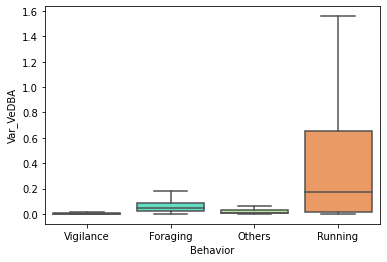

In [85]:
import seaborn as sns

#MAKE VIOLIN PLOTS

fig,ax = plt.subplots()
sns.boxplot(x='Behavior',y='Var_VeDBA',data=df[['Behavior','Var_VeDBA']], palette='rainbow',showfliers=False)
#plt.title("VeDBA Distribution Across Behavior")

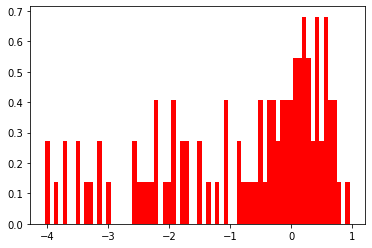

In [93]:
#plt.hist(np.log(df.loc[df['Behavior'] != 'Running','StdNorm']),bins=50,color='b',density='True')
plt.hist(df.loc[df['Behavior'] == 'Running','Log VeDBA'],bins=70,color='r',density='True') 
plt.show()

In [94]:
df.Behavior.value_counts()

Foraging     4513
Vigilance    1059
Others        422
Running       103
Walking        59
Name: Behavior, dtype: int64

In [95]:
df = df.drop(['StdNorm'], axis=1)


RF

In [96]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix,classification_report
from sklearn.decomposition import PCA


x=df.iloc[:,4:]  # Features
#x=df.iloc[:,4:]  # Features

y=df['Behavior']  # Labels


Scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42) # 80% training and 20% test

clf=RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42)


X_train = Scaler.fit_transform(X_train)

clf.fit(X_train,y_train)


X_test = Scaler.transform(X_test)

y_pred=clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

plt.figure(dpi=150)
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(y.unique()))
ax.yaxis.set_ticklabels(sorted(y.unique()))
#plt.tight_layout()
plt.show()

y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

ValueError: could not convert string to float: '2021-06-09'

SMOTE RF

Accuracy: 0.9074675324675324


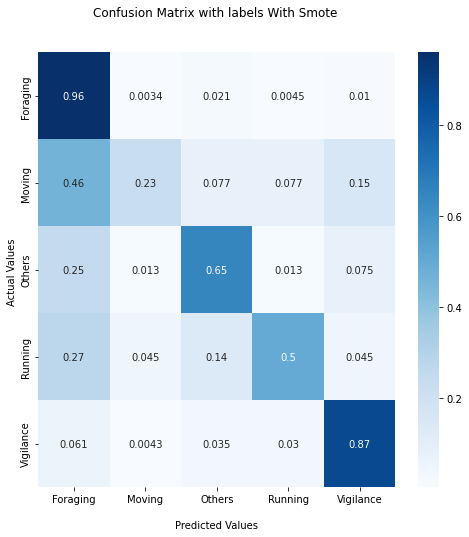

In [166]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()


x=df.iloc[:,4:]  # Features
y=df['Behavior']  # Labels


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42) # 80% training and 20% test

clf=RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)


X_train = Scaler.fit_transform(X_train)


X_train, y_train = oversample.fit_resample(X_train, y_train)

clf.fit(X_train,y_train)


X_test = Scaler.transform(X_test)

y_pred=clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

plt.figure(figsize=(8,8))
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels With Smote \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(y.unique()))
ax.yaxis.set_ticklabels(sorted(y.unique()))
plt.show()

In [101]:
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Foraging       1.00      1.00      1.00      3724
      Moving       1.00      1.00      1.00      3724
      Others       1.00      1.00      1.00      3724
     Running       1.00      1.00      1.00      3724
   Vigilance       1.00      1.00      1.00      3724

    accuracy                           1.00     18620
   macro avg       1.00      1.00      1.00     18620
weighted avg       1.00      1.00      1.00     18620



XGB

Accuracy: 0.909234411996843


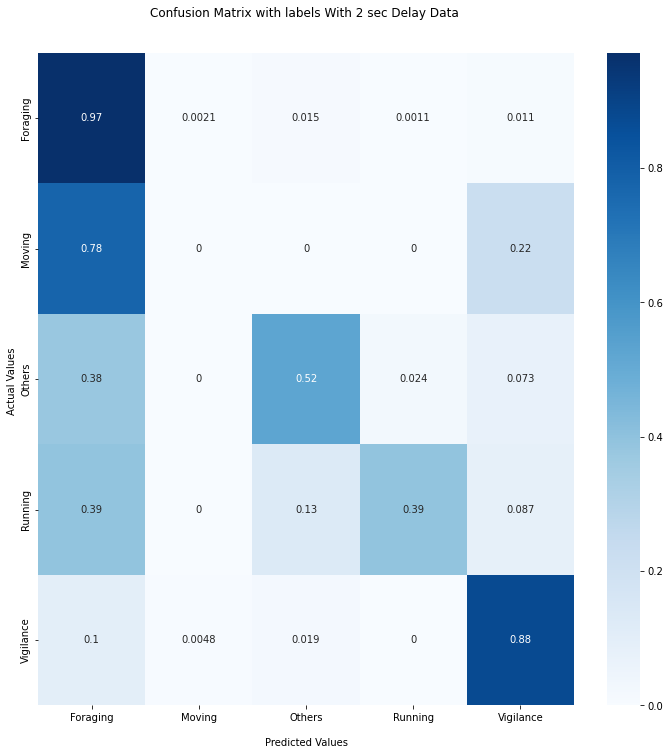

In [83]:
from sklearn.ensemble import GradientBoostingClassifier

x=df.iloc[:,4:]  # Features
#x=df.iloc[:,4:]  # Features




y=df['Behavior']  # Labels

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=42) 

clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

plt.figure(figsize=(12,12))
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels With 2 sec Delay Data \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(y.unique()))
ax.yaxis.set_ticklabels(sorted(y.unique()))
plt.show()

SVM

Accuracy: 0.8966061562746646


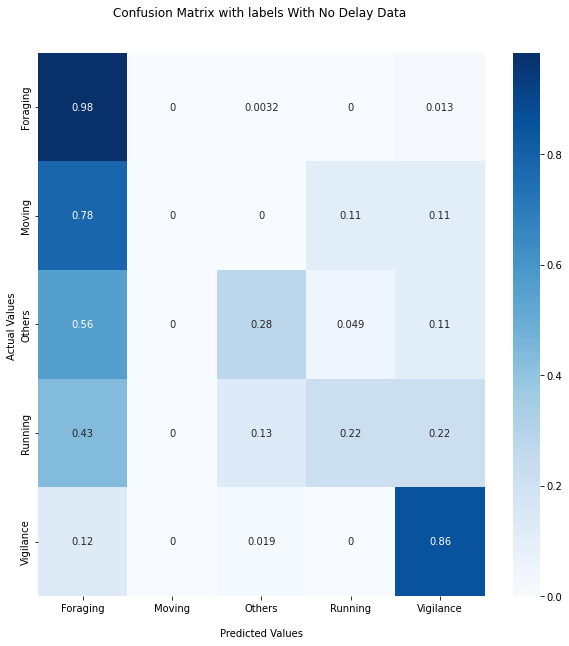

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix
from sklearn.decomposition import PCA

x=df.iloc[:,4:]  # Features
#X.iloc[:,-1] = np.log(X.iloc[:,-1]+1)

Scaler = StandardScaler()

y=df['Behavior']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42) # 80% training and 20% test


X_train = Scaler.fit_transform(X_train)

svclassifier = SVC(kernel='linear', gamma='scale')
svclassifier.fit(X_train, y_train)

X_test = Scaler.transform(X_test)

y_pred=svclassifier.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

plt.figure(figsize=(10,10))
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels With No Delay Data \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(y.unique()))
ax.yaxis.set_ticklabels(sorted(y.unique()))
plt.show()

KNN

Accuracy: 0.9076558800315706


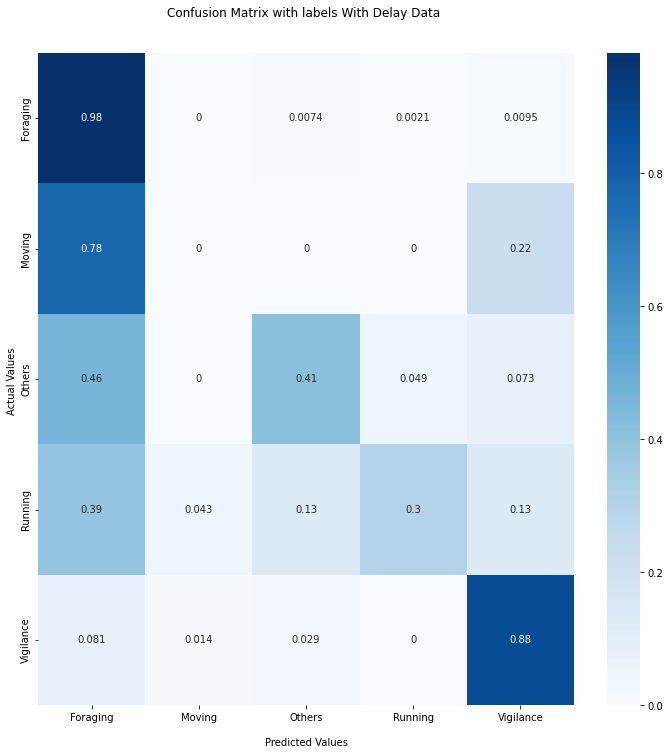

In [86]:
from sklearn.neighbors import KNeighborsClassifier

x=df.iloc[:,4:]  # Features

Scaler = StandardScaler()

y=df['Behavior']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42) # 80% training and 20% test


X_train = Scaler.fit_transform(X_train)


knn = KNeighborsClassifier(n_neighbors=15)


X_test = Scaler.transform(X_test)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

plt.figure(figsize=(12,12))
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels With Delay Data \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(y.unique()))
ax.yaxis.set_ticklabels(sorted(y.unique()))
plt.show()

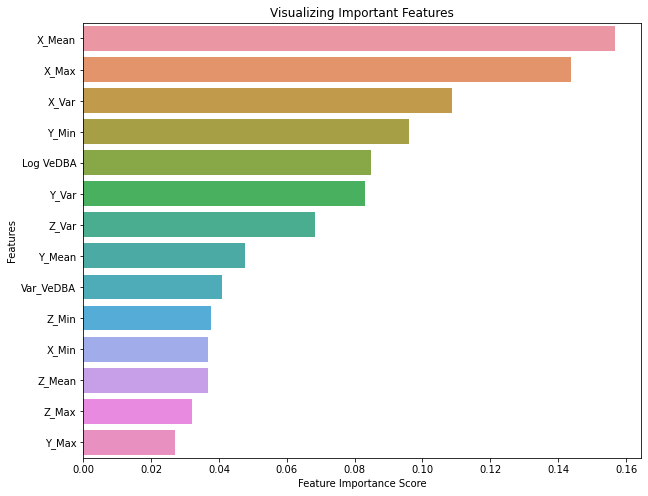

In [165]:
plt.figure(figsize=(10,8))
feature_imp = pd.Series(clf.feature_importances_,index=x.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

ALL

In [137]:
x=df.iloc[:,4:]  # Features
#x=df.iloc[:,4:]  # Features

y=df['Behavior']  # Labels


Scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42) # 80% training and 20% test

X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

Models = [RandomForestClassifier(),KNeighborsClassifier(),SVC(),GradientBoostingClassifier()]

for clf in Models:



    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf)
    print("Accuracy:",accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('\n')

RandomForestClassifier()
Accuracy: 0.9194948697711128
              precision    recall  f1-score   support

    Foraging       0.94      0.98      0.96       943
      Moving       0.43      0.33      0.38         9
      Others       0.70      0.51      0.59        82
     Running       0.67      0.43      0.53        23
   Vigilance       0.92      0.88      0.90       210

    accuracy                           0.92      1267
   macro avg       0.73      0.63      0.67      1267
weighted avg       0.91      0.92      0.91      1267



KNeighborsClassifier()
Accuracy: 0.9131807419100236
              precision    recall  f1-score   support

    Foraging       0.93      0.98      0.95       943
      Moving       0.29      0.22      0.25         9
      Others       0.71      0.50      0.59        82
     Running       0.67      0.52      0.59        23
   Vigilance       0.92      0.85      0.89       210

    accuracy                           0.91      1267
   macro avg       0.70